In [146]:
import os
import re

os.chdir("/home/s2113174/Projects-1")

import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

from collections import OrderedDict

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pyDOE import lhs
from scipy.stats import uniform,norm

from Galab import llaplace

np.random.seed(1234)

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

## Burgers Equation

$$\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} - \frac{0.01}{\pi}\frac{\partial^{2} u}{\partial x^{2}}=0$$
$$u(x,0) = -sin( \pi x),  u(-1,t)=u(1,t)=0$$

## Feed Forward Neural Network

In [147]:
# Deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()

        # Number of layers
        self.depth = len(layers) - 1
        
        # Activation Function
        self.activation = torch.nn.Tanh
        
        # The following loop organized the layers of the NN         
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1])))
            layer_list.append(('activation_%d' % i, self.activation()))
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # Deploy layers
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

## Parametric PINN for Inverse Problems

In [148]:
def de(self,data_domain):
    """ The pytorch autograd version of calculating residual """
    u = self(data_domain)
    
    du = torch.autograd.grad(
        u, data_domain, 
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]

    ddu_x = torch.autograd.grad(
        du[:,0],data_domain, 
        grad_outputs=torch.ones_like(du[:,0]),
        retain_graph=True,
        create_graph=True
        )[0]
    
    f = du[:,1].reshape(-1,1) + u.reshape(-1,1)*du[:,0].reshape(-1,1) - data_domain[:,2].reshape(-1,1)*ddu_x[:,0].reshape(-1,1)

    return f

def ini_c(self,data_inic):
    u = self(data_inic)
    return u + torch.sin(torch.pi*data_inic[:,0].reshape(-1,1))

def left_bc(self,data_lbc):
    u = self(data_lbc)
    return u

def right_bc(self,data_rbc):
    u = self(data_rbc)
    return u

In [149]:
DNN.de = de
DNN.ini_c = ini_c
DNN.left_bc = left_bc
DNN.right_bc = right_bc

In [150]:
def samples_space(size,maxl):
    t_f_train = lhs(2, size)*maxl
    t_f_train[:,0] = t_f_train[:,0]*(2)-1
    return t_f_train

def samples_param(min,max,size = 100):
    return np.random.uniform(min,max,size = size)

In [151]:
def data_pde(size,maxl,minp,maxp):

    xy, param = samples_space(size,maxl),samples_param(minp,maxp,(size,1)).reshape(-1,1)
    pde_domain = torch.tensor(np.hstack((xy,param.reshape(-1,1)))).float()
    
    x,y, param  = torch.tensor(xy[:,0]).reshape(-1,1),torch.tensor(xy[:,1]).reshape(-1,1),torch.tensor(param).reshape(-1,1)

    ini_c = torch.cat([x,torch.zeros_like(x).float(),param],axis = 1).float()

    left_bc = torch.cat([torch.ones_like(x).float()*(-1),y, param],axis = 1).float()

    right_bc = torch.cat([torch.ones_like(x).float(),y, param],axis = 1).float()

    return pde_domain,ini_c,left_bc,right_bc

In [152]:
def train_adam(pinn,loss,optimizer,epochs, sample_size = 100, bound_limit = 1,minval_param = 0.2,maxval_param = 2,repetitions=1):
      print("Starting Adam Training")
      train_loss=[]
      for i in range(epochs):
        pde_domain,ini_c,left_bc,right_bc = data_pde(sample_size,bound_limit,minval_param,maxval_param)
        
        pde_domain,ini_c = Variable(pde_domain,requires_grad=True),Variable(ini_c,requires_grad=True)
        left_bc,right_bc = Variable(left_bc,requires_grad=True),Variable(right_bc,requires_grad=True)
        
        for _ in range(repetitions):
                optimizer.zero_grad()

                pde_pred,ini_c_pred = pinn.de(pde_domain), pinn.ini_c(ini_c)
                left_bc_pred,right_bc_pred = pinn.left_bc(left_bc),pinn.right_bc(right_bc)

                loss_pde,loss_ini = loss(pde_pred,torch.zeros_like(pde_pred)),loss(ini_c_pred,torch.zeros_like(pde_pred))
                loss_lbc,loss_rbc = loss(left_bc_pred,torch.zeros_like(pde_pred)),loss(right_bc_pred,torch.zeros_like(pde_pred))

                Loss =  loss_pde + loss_ini + loss_lbc + loss_rbc
                train_loss.append(Loss.item())
                if i % 10 == 0:
                        print('Iter %d, Loss: %.5e, Loss_PDE: %.5e, Loss_ini: %.5e, Loss_lbc: %.5e,Loss_rbc: %.5e' % (i, 
                                                                         Loss.item(),loss_pde.item(),loss_ini.item(), loss_lbc.item(), loss_rbc.item()))
                                
                Loss.backward() 

                optimizer.step() 

                #sheduler.step()
      return train_loss

In [153]:
def train_LBFGS(pinn,loss,optimizer, sample_size = 100, bound_limit = 1,minval_param = 0.2,maxval_param = 2):
    print("Starting Training: LBFGS optimizer")
    train_loss=[]

    pde_domain,ini_c,left_bc,right_bc = data_pde(sample_size,bound_limit,minval_param,maxval_param)
    
    pde_domain,ini_c = Variable(pde_domain,requires_grad=True),Variable(ini_c,requires_grad=True)
    left_bc,right_bc = Variable(left_bc,requires_grad=True),Variable(right_bc,requires_grad=True)
    

    def loss_func_train():
        optimizer.zero_grad()
        
        pde_pred,ini_c_pred = pinn.de(pde_domain), pinn.ini_c(ini_c)
        left_bc_pred,right_bc_pred = pinn.left_bc(left_bc),pinn.right_bc(right_bc)

        loss_pde,loss_ini = loss(pde_pred,torch.zeros_like(pde_pred)),loss(ini_c_pred,torch.zeros_like(pde_pred))
        loss_lbc,loss_rbc = loss(left_bc_pred,torch.zeros_like(pde_pred)),loss(right_bc_pred,torch.zeros_like(pde_pred))

        Loss =  loss_pde + loss_ini + loss_lbc + loss_rbc
        train_loss.append(Loss.item())

        print('Loss: %.5e, Loss_PDE: %.5e, Loss_ini: %.5e, Loss_lbc: %.5e,Loss_rbc: %.5e' % ( 
                                                            Loss.item(),loss_pde.item(),loss_ini.item(), loss_lbc.item(), loss_rbc.item()))

        Loss.backward() 

        return Loss

    optimizer.step(loss_func_train) 
    return train_loss

In [154]:
# Number of observations
nobs = 100
lr = 0.01

min_param , max_param = 0.0001, 0.05

space = 1

layers = [3] + 4*[30] + [1]

model = DNN(layers)

# model.load_state_dict(torch.load(f"../Projects-1/Physics _Informed_NN/GaLA/Gala_models/BurgEq_4_30.pt"))
# model.eval()

In [155]:
epochs = 2000

model = DNN(layers)
loss = torch.nn.MSELoss(reduction ='mean')

optimizer = torch.optim.Adam(model.parameters(), lr = lr)

loss_history = train_adam(model,loss,optimizer,epochs, nobs,space,min_param,max_param)

optimizer = torch.optim.LBFGS(
    model.parameters(), lr=lr, max_iter=50000, max_eval=None, tolerance_grad=1e-5, tolerance_change=1.0 * np.finfo(float).eps,line_search_fn="strong_wolfe" 
    )

loss_history_b = train_LBFGS(model,loss,optimizer, nobs*2,space,min_param,max_param)

Starting Adam Training
Iter 0, Loss: 5.91636e-01, Loss_PDE: 1.12433e-04, Loss_ini: 5.10085e-01, Loss_lbc: 5.49757e-02,Loss_rbc: 2.64634e-02
Iter 10, Loss: 4.35123e-01, Loss_PDE: 7.90550e-04, Loss_ini: 4.09035e-01, Loss_lbc: 9.07737e-03,Loss_rbc: 1.62207e-02


Iter 20, Loss: 3.07275e-01, Loss_PDE: 1.52575e-03, Loss_ini: 2.61838e-01, Loss_lbc: 1.45233e-02,Loss_rbc: 2.93878e-02
Iter 30, Loss: 2.42627e-01, Loss_PDE: 1.14727e-01, Loss_ini: 4.88850e-02, Loss_lbc: 2.79180e-02,Loss_rbc: 5.10963e-02
Iter 40, Loss: 1.64748e-01, Loss_PDE: 2.92877e-02, Loss_ini: 9.61419e-02, Loss_lbc: 1.62592e-02,Loss_rbc: 2.30595e-02
Iter 50, Loss: 1.50124e-01, Loss_PDE: 6.06287e-02, Loss_ini: 7.81688e-02, Loss_lbc: 8.22436e-03,Loss_rbc: 3.10207e-03
Iter 60, Loss: 1.20894e-01, Loss_PDE: 3.05464e-02, Loss_ini: 8.00912e-02, Loss_lbc: 5.35514e-03,Loss_rbc: 4.90166e-03
Iter 70, Loss: 1.33554e-01, Loss_PDE: 6.56561e-02, Loss_ini: 5.71485e-02, Loss_lbc: 3.25910e-03,Loss_rbc: 7.49003e-03
Iter 80, Loss: 1.21539e-01, Loss_PDE: 5.74612e-02, Loss_ini: 5.28270e-02, Loss_lbc: 4.57896e-03,Loss_rbc: 6.67198e-03
Iter 90, Loss: 1.24186e-01, Loss_PDE: 4.67107e-02, Loss_ini: 6.85037e-02, Loss_lbc: 4.17452e-03,Loss_rbc: 4.79748e-03
Iter 100, Loss: 1.03439e-01, Loss_PDE: 4.44525e-02, Loss

In [158]:
epochs = 200

model2 = DNN(layers)
loss = torch.nn.MSELoss(reduction ='mean')

optimizer = torch.optim.Adam(model2.parameters(), lr = lr)

loss_history_2 = train_adam(model2,loss,optimizer,epochs, nobs,space,min_param,max_param,repetitions=10)


optimizer = torch.optim.LBFGS(
    model2.parameters(), lr=lr, max_iter=50000, max_eval=None, tolerance_grad=1e-5, tolerance_change=1.0 * np.finfo(float).eps,line_search_fn="strong_wolfe" 
    )

loss_history_2b = train_LBFGS(model2,loss,optimizer, nobs*2,space,min_param,max_param)


Starting Adam Training
Iter 0, Loss: 6.07543e-01, Loss_PDE: 5.79942e-05, Loss_ini: 5.46623e-01, Loss_lbc: 3.79262e-02,Loss_rbc: 2.29361e-02
Iter 0, Loss: 4.96226e-01, Loss_PDE: 3.93456e-03, Loss_ini: 4.68492e-01, Loss_lbc: 2.11592e-02,Loss_rbc: 2.64030e-03
Iter 0, Loss: 4.68108e-01, Loss_PDE: 2.13753e-03, Loss_ini: 4.34880e-01, Loss_lbc: 3.00287e-02,Loss_rbc: 1.06175e-03
Iter 0, Loss: 4.53453e-01, Loss_PDE: 5.31502e-04, Loss_ini: 4.20101e-01, Loss_lbc: 7.32812e-03,Loss_rbc: 2.54924e-02
Iter 0, Loss: 4.65323e-01, Loss_PDE: 6.38685e-04, Loss_ini: 4.04765e-01, Loss_lbc: 5.44091e-03,Loss_rbc: 5.44783e-02
Iter 0, Loss: 4.51531e-01, Loss_PDE: 1.19771e-03, Loss_ini: 3.82272e-01, Loss_lbc: 2.16244e-02,Loss_rbc: 4.64377e-02
Iter 0, Loss: 4.49297e-01, Loss_PDE: 1.35623e-03, Loss_ini: 3.82250e-01, Loss_lbc: 4.27154e-02,Loss_rbc: 2.29763e-02
Iter 0, Loss: 4.51998e-01, Loss_PDE: 9.21692e-04, Loss_ini: 4.05446e-01, Loss_lbc: 3.71679e-02,Loss_rbc: 8.46207e-03
Iter 0, Loss: 4.50883e-01, Loss_PDE: 6.91

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


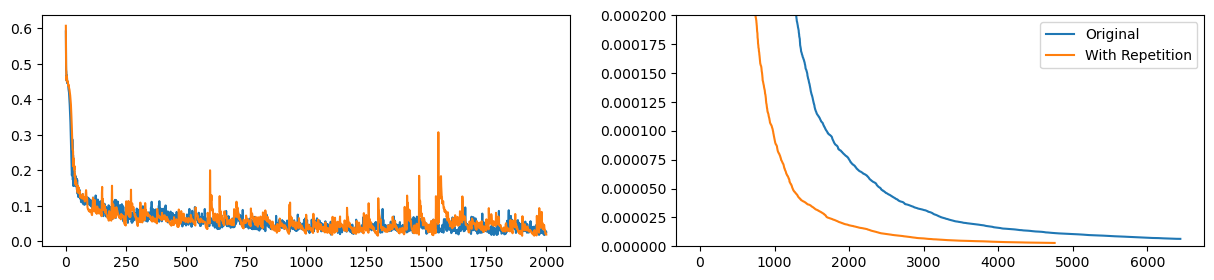

In [159]:
fig, axs = plt.subplots(1,2, figsize=(15, 3))
axs[0].plot(loss_history,label="Original")
axs[0].plot(loss_history_2,label = "With Repetition")
#axs.set_ylim((0,0.2))
plt.legend()

axs[1].plot(loss_history_b,label="Original")
axs[1].plot(loss_history_2b,label = "With Repetition")
axs[1].set_ylim((0,0.0002))
plt.legend()

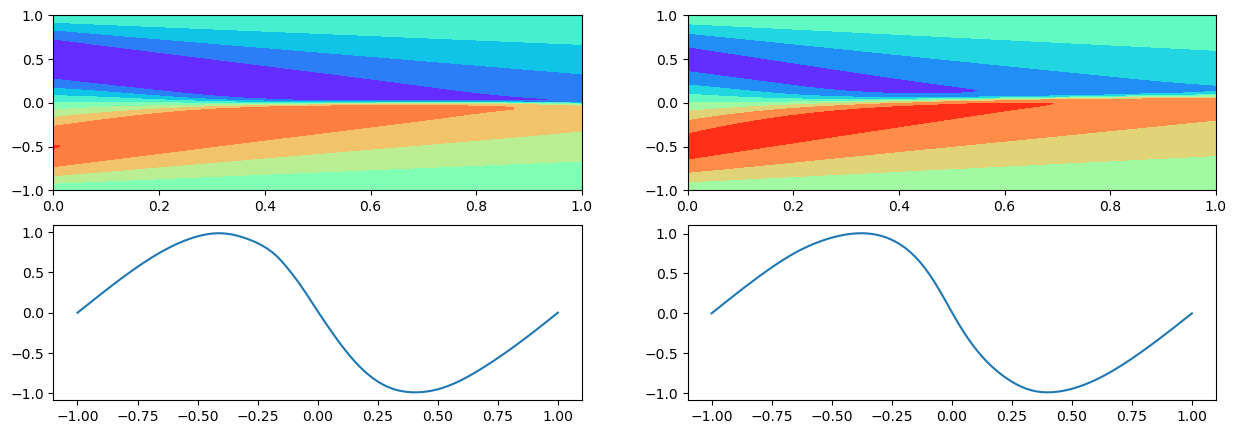

In [160]:
from scipy.interpolate import griddata

x = np.linspace(-1,1,100)
y = np.linspace(0,1,100)

xx, yy = np.meshgrid(x, y)
xx, yy = torch.tensor(xx).reshape(-1,1).float(),torch.tensor(yy).reshape(-1,1).float()


X_star = torch.cat([xx,yy,torch.ones_like(xx)*(0.005)],axis = 1)

fig, axs = plt.subplots(2,2, figsize=(15, 5))

znn = model(X_star)
xx,yy = np.meshgrid(x, y)
U_pred = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), znn.detach().numpy().flatten(), (xx,yy), method='cubic')
axs[0,0].contourf(y.flatten(), x.flatten(), U_pred.T,cmap='rainbow')
axs[1,0].plot(x,U_pred[10,:])

znn = model2(X_star)
xx,yy = np.meshgrid(x, y)
U_pred = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), znn.detach().numpy().flatten(), (xx,yy), method='cubic')
axs[0,1].contourf(y.flatten(), x.flatten(), U_pred.T,cmap='rainbow')
axs[1,1].plot(x,U_pred[10,:])


In [11]:
#torch.save(model.state_dict(),"Param_model_2.pt")

pde_domain,ini_c,left_bc,right_bc = data_pde(nobs,space,min_param,max_param)

pde = {"PDE":["de","ini_c","left_bc","right_bc"], 
       "data_set":{"de" : Variable(pde_domain,requires_grad=True),
                   "ini_c" : ini_c,
                   "left_bc":left_bc,
                   "right_bc" :right_bc}}

llp = llaplace(model,sigma_noise=1, prior_precision=1)
llp.fit(pde=pde, hessian_structure = "full")

log_prior, log_sigma = torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True)
hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
for i in range(1000):
    hyper_optimizer.zero_grad()
    neg_marglik = - llp.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward(retain_graph=True)
    hyper_optimizer.step()
    print(log_prior,log_sigma)

tensor([1.1000], requires_grad=True) tensor([0.9000], requires_grad=True)
tensor([1.2000], requires_grad=True) tensor([0.8003], requires_grad=True)
tensor([1.3000], requires_grad=True) tensor([0.7013], requires_grad=True)
tensor([1.3998], requires_grad=True) tensor([0.6036], requires_grad=True)
tensor([1.4996], requires_grad=True) tensor([0.5082], requires_grad=True)
tensor([1.5992], requires_grad=True) tensor([0.4168], requires_grad=True)
tensor([1.6986], requires_grad=True) tensor([0.3319], requires_grad=True)
tensor([1.7974], requires_grad=True) tensor([0.2574], requires_grad=True)
tensor([1.8957], requires_grad=True) tensor([0.1978], requires_grad=True)
tensor([1.9929], requires_grad=True) tensor([0.1568], requires_grad=True)
tensor([2.0888], requires_grad=True) tensor([0.1356], requires_grad=True)
tensor([2.1826], requires_grad=True) tensor([0.1327], requires_grad=True)
tensor([2.2736], requires_grad=True) tensor([0.1449], requires_grad=True)
tensor([2.3607], requires_grad=True) t

tensor([2.3511], requires_grad=True) tensor([0.2774], requires_grad=True)
tensor([2.3357], requires_grad=True) tensor([0.2787], requires_grad=True)
tensor([2.3252], requires_grad=True) tensor([0.2839], requires_grad=True)
tensor([2.3192], requires_grad=True) tensor([0.2924], requires_grad=True)
tensor([2.3175], requires_grad=True) tensor([0.3032], requires_grad=True)
tensor([2.3197], requires_grad=True) tensor([0.3154], requires_grad=True)
tensor([2.3252], requires_grad=True) tensor([0.3279], requires_grad=True)
tensor([2.3335], requires_grad=True) tensor([0.3399], requires_grad=True)
tensor([2.3441], requires_grad=True) tensor([0.3505], requires_grad=True)
tensor([2.3564], requires_grad=True) tensor([0.3591], requires_grad=True)
tensor([2.3698], requires_grad=True) tensor([0.3652], requires_grad=True)
tensor([2.3838], requires_grad=True) tensor([0.3687], requires_grad=True)
tensor([2.3979], requires_grad=True) tensor([0.3695], requires_grad=True)
tensor([2.4118], requires_grad=True) t

In [72]:
import scipy.io

data = scipy.io.loadmat('../Projects-1/Physics _Informed_NN/Pytorch/burgers_shock.mat')
y = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]

Exact = np.real(data['usol']).T

xx, yy = np.meshgrid(x, y)

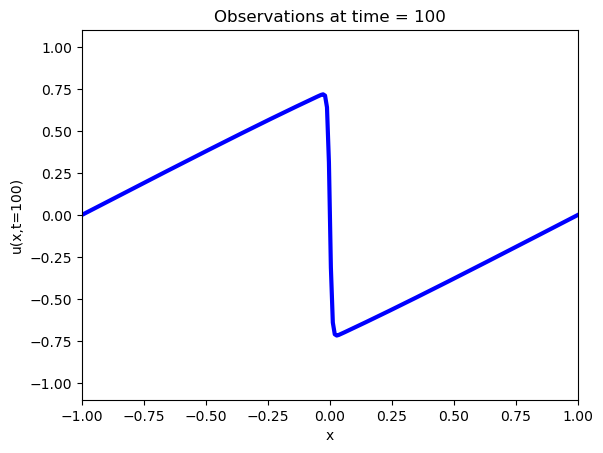

In [73]:
# from matplotlib.animation import FuncAnimation, PillowWriter
# fig,ax = plt.subplots()

# def animate(i):
#     ax.clear()
#     ax.set_title(f"Observations at time = {i+1}")
#     ax.set_xlabel("x")
#     ax.set_ylabel(fr"u(x,t={i+1})")
#     ax.set_ylim((-1.1,1.1))
#     ax.set_xlim((-1,1))
#     img = ax.plot(x,Exact[i,:],color = "blue", linewidth = 3)

#     return img

# ani = FuncAnimation(fig, animate, interval=5, blit=True, repeat=True, frames=100)    
# ani.save("TLI.gif", dpi=300, writer=PillowWriter(fps=25))

In [39]:
from scipy.interpolate import griddata

x,t = np.linspace(-1,1,250),np.linspace(0,1.5,250)

xx, yy = np.meshgrid(x, t)
xx, yy = torch.tensor(xx).reshape(-1,1).float(),torch.tensor(yy).reshape(-1,1).float()

X_star1 = torch.cat([xx,yy,torch.ones_like(xx)*(0.01/np.pi)],axis = 1)
X_star2 = torch.cat([xx,yy,torch.ones_like(xx)*(0.06)],axis = 1)

xx, yy = np.meshgrid(x, t)

f_mu1, f_sigma1 = llp(X_star1)
f_mu1, f_sigma1 = f_mu1.cpu().numpy(), f_sigma1.squeeze().sqrt().cpu().numpy().reshape(-1,1)

z_pred1 = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_mu1.flatten(), (xx,yy), method='cubic')
z_pred_var1 = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_sigma1.flatten(), (xx,yy), method='cubic')

f_mu2, f_sigma2 = llp(X_star2)
f_mu2, f_sigma2 = f_mu2.cpu().numpy(), f_sigma2.squeeze().sqrt().cpu().numpy().reshape(-1,1)

z_pred2 = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_mu2.flatten(), (xx,yy), method='cubic')
z_pred_var2 = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_sigma2.flatten(), (xx,yy), method='cubic')

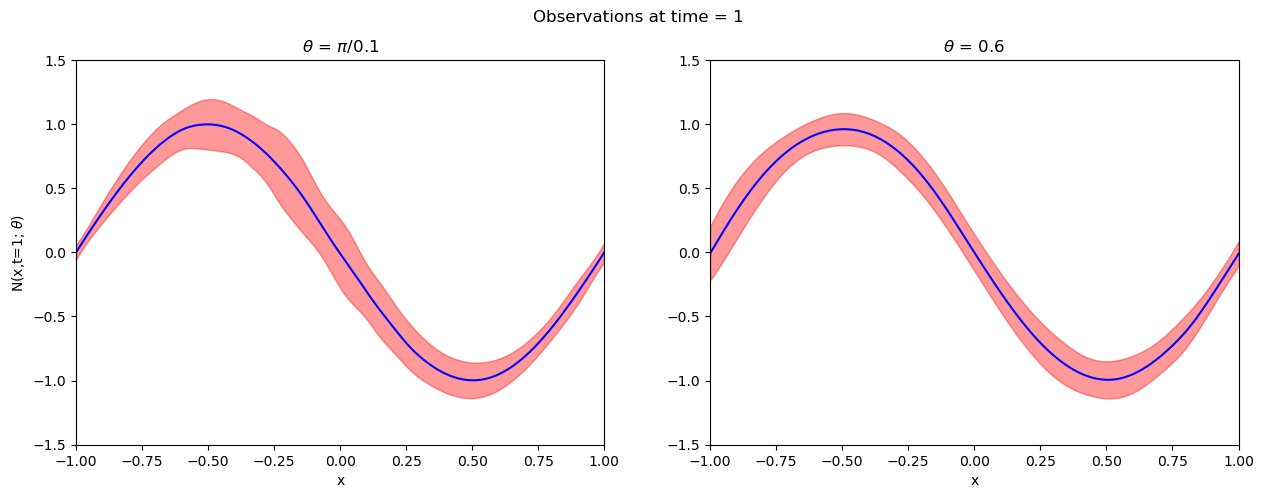

In [61]:
from matplotlib.animation import FuncAnimation, PillowWriter

fig,ax = plt.subplots(1,2,figsize=(15,5))

def animate(i):
    if i > 166:
        plt.suptitle(f"Observations at time = {i+1}", color = "red")
    else:
        plt.suptitle(f"Observations at time = {i+1}")

    ax[0].clear()
    ax[1].clear()

    ax[0].set_title(fr"$\theta$ = $\pi/0.1$")
    ax[0].set_xlabel("x")
    ax[0].set_ylabel(fr"N(x,t={i+1}; $\theta$)")
    ax[0].set_ylim((-1.5,1.5))
    ax[0].set_xlim((-1,1))

    ax[1].set_title(fr"$\theta$ = 0.6")
    ax[1].set_xlabel("x")
    ax[1].set_ylim((-1.5,1.5))
    ax[1].set_xlim((-1,1))

    img1 = ax[0].plot(x,z_pred1[i,:],color = "blue")
    img2 = ax[0].fill_between(x.reshape(-1), z_pred1[i,:]+2*z_pred_var1[i,:],z_pred1[i,:]-2*z_pred_var1[i,:],alpha=0.4, color = "red")

    img3 = ax[1].plot(x,z_pred2[i,:],color = "blue")
    img4 = ax[1].fill_between(x.reshape(-1), z_pred2[i,:]+2*z_pred_var2[i,:],z_pred2[i,:]-2*z_pred_var2[i,:],alpha=0.4, color = "red")

    return img1,img2,img3,img4

ani = FuncAnimation(fig, animate, interval=5, blit=False, repeat=True, frames=250)    
ani.save("TLIb.gif", dpi=300, writer=PillowWriter(fps=25))

In [ ]:
from matplotlib.animation import FuncAnimation, PillowWriter
fig,ax = plt.subplots()

def animate(i):
    ax.clear()
    ax.set_title(f"Observations at time = {i+1}")
    ax.set_xlabel("x")
    ax.set_ylabel(fr"u(x,t={i+1})")
    ax.set_ylim((-1.1,1.1))
    ax.set_xlim((-1,1))
    img = ax.plot(x,Exact[i,:],color = "blue", linewidth = 3)

    return img

ani = FuncAnimation(fig, animate, interval=40, blit=True, repeat=True, frames=100)    
ani.save("TLI.gif", dpi=300, writer=PillowWriter(fps=25))




In [60]:
param_trained =  samples_param(min_param , max_param,6)
from scipy.interpolate import griddata


# Plotting
fig = plt.figure(figsize=(25,25))
plt.subplots_adjust(hspace=0.25)

for n,pr in enumerate(param_trained):
    
    xx, yy = torch.tensor(xx).reshape(-1,1).float(),torch.tensor(yy).reshape(-1,1).float()

    X_star = torch.cat([xx,yy,torch.ones_like(xx)*pr],axis = 1)

    u_pred = model(X_star).detach().cpu().numpy()

    f_mu, f_sigma = llp(X_star)

    f_mu, f_sigma= f_mu.cpu().numpy(), f_sigma.squeeze().sqrt().cpu().numpy().reshape(-1,1)
    
    xx,yy = np.meshgrid(x, y)

    z_pred = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_mu.flatten(), (xx,yy), method='cubic')
    z_pred_var = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_sigma.flatten(), (xx,yy), method='cubic')

    z_exact = Exact
    
    plt.subplot(8, 2, n + 1)

    plt.plot(x,z_pred[-1,:],color = "blue")
    plt.fill_between(x.reshape(-1), z_pred[-1,:]+2*z_pred_var[-1,:],z_pred[-1,:]-2*z_pred_var[-1,:],alpha=0.4, color = "red")
    plt.plot(x,z_exact[-1,:],linestyle = "--",color = "black")

    plt.xlabel("x")
    plt.ylabel(r'u(x,t)')
    #plt.legend(frameon=False)

NameError: name 'xx' is not defined

<Figure size 2500x2500 with 0 Axes>

## MCMC Step

In [76]:
def log_prior_alpha(alpha): #function to evaluate prior pdf of given parameters
    return norm.logpdf(alpha,loc = 0,scale = 1.5)

def proposals(alpha,dt):
    return np.random.normal(alpha,dt)

In [125]:
def log_likelihood_marginal(surrogate,alpha,xx,yy,y_dat,sig = 0.0001):

    X_star = torch.cat([xx,yy,torch.ones_like(xx)*alpha],axis = 1)

    surg_mu, surg_sigma = surrogate(X_star.float())
    surg_mu, surg_sigma = surg_mu.to(torch.float64).cpu().numpy().reshape(-1),surg_sigma.to(torch.float64).squeeze().cpu().numpy()
    #return np.sum(-np.log(np.sqrt(2* np.pi*sig)) - ((y_dat-surg)**2) / (2*sig))

    #return np.sum(- ((y_dat-surg_mu)**2) / (2*(sig**2+surg_sigma))) - (0.5)*np.sum(np.log(sig**2+surg_sigma)) -  y_dat.shape[0]*(0.5)*np.log(2*np.pi) 
    return np.sum(- ((y_dat-surg_mu)**2) / (2*(sig**2+surg_sigma)))

# def log_likelihood(surrogate,alpha,t,y_dat,sig = 0.0001):
    
#     data_ = np.hstack((t.flatten()[:,None], np.ones_like(t).flatten()[:,None]*(alpha)))

#     surg = surrogate(torch.tensor(data_).float()).detach().cpu().numpy().reshape(-1,)
        
#     #return np.sum(-np.log(np.sqrt(2* np.pi*sig)) - ((y_dat-surg)**2) / (2*sig))

    return np.sum(- ((y_dat-surg)**2) / (2*sig**2))

# def log_likelihood_ex(alpha,t,y,sig = 0.0001):

#     surg_exact = (t - t**2) / (2*np.exp(alpha))

#     #return np.sum(-np.log(np.sqrt(2* np.pi*sig**2)) - ((y-surg_exact)**2) / (2*sig**2))
#     return np.sum(-((y-surg_exact)**2) / (2*sig**2))

In [126]:
# def log_posterior_ex(alpha,t,y):
#     return  log_likelihood_ex(alpha,t,y) + log_prior_alpha(alpha)

def log_posterior_nn_marginal(model,alpha,xx,yy,y):
    return  log_likelihood_marginal(model,alpha,xx,yy,y) + log_prior_alpha(alpha)
#    return  log_likelihood(model,alpha,t,y) 

# def log_posterior_nn(model,alpha,t,y):
#     return  log_likelihood(model,alpha,t,y) + log_prior_alpha(alpha)

In [64]:
# theta_h = 0.314
# t, noise_sol_test = test_set(ns,1000,theta_h,mean,std)

In [65]:
# data_ = np.hstack((t.flatten()[:,None], np.ones_like(t).flatten()[:,None]*(0.5)))

# surg_mu, surg_sigma = llp(torch.tensor(data_).float())
# surg_mu, surg_sigma = surg_mu.cpu().numpy().reshape(-1),surg_sigma.squeeze().cpu().numpy()

# print(np.sum(- ((noise_sol_test-surg_mu)**2) / (2*(std**2+surg_sigma))))

# #np.sum(- ((y_dat-surg_mu)**2) / (2*(sig**2+surg_sigma))) - (0.5)*np.sum(np.log(sig**2+surg_sigma)) -  y_dat.shape[0]*(0.5)*np.log(2*np.pi) 


In [127]:
alpha_ = np.linspace(-1,1,2000)

alpha_fc,alpha_fc_2,alpha_fc_3 = [],[],[]
alpha_fc_nn,alpha_fc_2_nn,alpha_fc_3_nn = [],[],[]
xx, yy = torch.tensor(xx).reshape(-1,1).float(),torch.tensor(yy).reshape(-1,1).float()

for alp in alpha_:
    # alpha_fc_nn.append(log_posterior_nn_marginal(llp,alp,t[:50],Exact.flatten()[:50]))
    
    # alpha_fc_2_nn.append(log_posterior_nn_marginal(llp,alp,t[:500],Exact.flatten()[:500]))
    
    alpha_fc_3_nn.append(log_posterior_nn_marginal(llp,alp,xx,yy,Exact.flatten()))

/tmp/ipykernel_22858/3999609544.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xx, yy = torch.tensor(xx).reshape(-1,1).float(),torch.tensor(yy).reshape(-1,1).float()


In [128]:
np.exp(alpha_fc_3_nn)

array([0., 0., 0., ..., 0., 0., 0.])

/tmp/ipykernel_22858/3514667346.py:18: RuntimeWarning: invalid value encountered in divide
  plt.plot(alpha_,200*np.exp(alpha_fc_3_nn)/np.sum(np.exp(alpha_fc_3_nn)), label = "all obs")


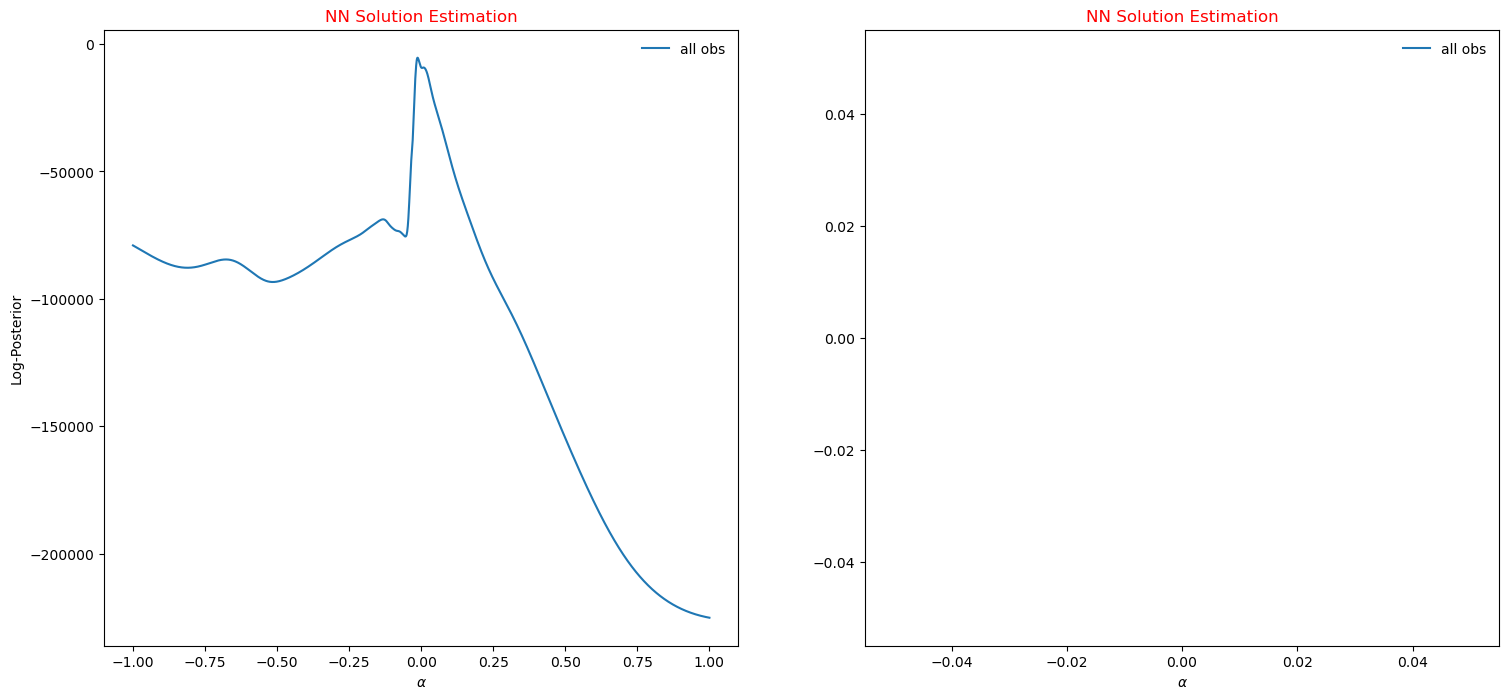

In [129]:
fig = plt.figure(figsize=(18,8))
plt.subplots_adjust(hspace=0.25)


plt.subplot(1, 2, 1)
plt.plot(alpha_,alpha_fc_3_nn, label = "all obs")

#plt.axvline(x = theta_h, color = 'black', label = 'Real')

plt.title("NN Solution Estimation",color = "red")
plt.ylabel("Log-Posterior")
plt.xlabel(r"$\alpha$")
plt.legend(frameon =False)



plt.subplot(1,2 , 2)
plt.plot(alpha_,200*np.exp(alpha_fc_3_nn)/np.sum(np.exp(alpha_fc_3_nn)), label = "all obs")

#plt.axvline(x = theta_h, color = 'black', label = 'Real')

plt.title("NN Solution Estimation",color = "red")
plt.xlabel(r"$\alpha$")
#plt.xlim(0,0.5)
plt.legend(frameon =False)

In [72]:
def Metropolis_Hastings_marginal(y_dat,nChains):

    alpha = 0.5

    alpha_samp = []
    acceptance_rate, dt = 0, 0.5

    dt_tracker = []
    for i in range(nChains):

        log_posterior =  log_posterior_nn_marginal(llp,alpha,y_dat)
        #log_posterior = log_posterior_ex(alpha,t,y_dat)

        alpha_proposal = proposals(alpha,dt)

        log_posterior_proposal = log_posterior_nn_marginal(llp,alpha_proposal,y_dat)
        #log_posterior_proposal = log_posterior_ex(alpha_proposal,t,y_dat)

        accept_u = np.random.uniform(0,1)

        ratio = np.exp(log_posterior_proposal-log_posterior, dtype=np.float64)

        a = np.min([1.,ratio])

        if accept_u < a:
            alpha = alpha_proposal
            acceptance_rate += 1
        
        dt = dt + dt*(a - 0.234)/ (i+1) 
        dt_tracker.append(dt)
        alpha_samp.append(alpha)


    print(f"Acceptance Rate: {acceptance_rate/nChains:.3f}")

    return alpha_samp,dt_tracker

In [69]:
def acf(x, length=20):
    return np.array([1]+[np.corrcoef(x[:-i], x[i:])[0,1] for i in range(1, length)])

In [ ]:
data = scipy.io.loadmat('../Projects-1/Physics _Informed_NN/Pytorch/burgers_shock.mat')

y = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]

Exact = np.real(data['usol']).T

xx, yy = np.meshgrid(x, y)

xx, yy = torch.tensor(xx).reshape(-1,1).float(),torch.tensor(yy).reshape(-1,1).float()

In [73]:
alpha_samp_marginal,dt_tracker_marginal = Metropolis_Hastings_marginal(Exact.flatten(),100000)

/tmp/ipykernel_22858/3094543993.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  surg_mu, surg_sigma = surrogate(torch.tensor(X_star).float())
/tmp/ipykernel_22858/1286672319.py:21: RuntimeWarning: overflow encountered in exp
  ratio = np.exp(log_posterior_proposal-log_posterior, dtype=np.float64)


Acceptance Rate: 0.001


Text(0.5, 0, 'Iteration')

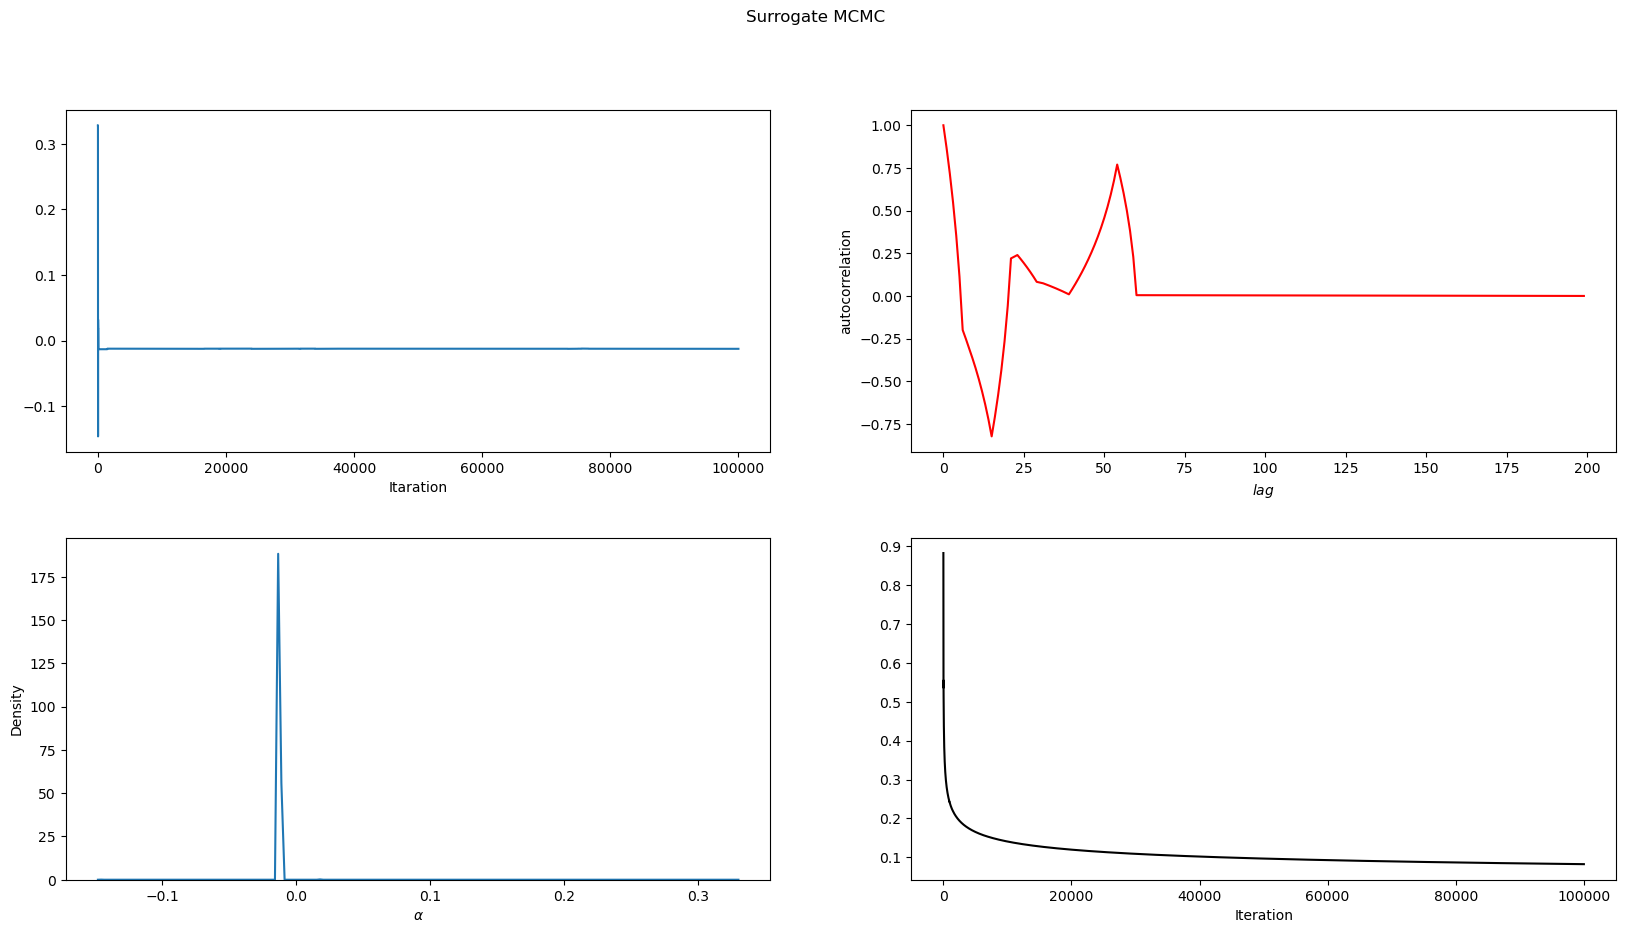

In [74]:
import seaborn as sns

fig = plt.figure(figsize=(20,10))
plt.suptitle("Surrogate MCMC")
plt.subplots_adjust(hspace=0.25)

plt.subplot(2, 2, 1)
plt.plot(alpha_samp_marginal)
plt.xlabel("Itaration")
#plt.ylim(0.3,0.35)

plt.subplot(2, 2, 2)
plt.plot(acf(alpha_samp_marginal,200),color = "red")
plt.xlabel(r"$lag$")
plt.ylabel(r"autocorrelation")


plt.subplot(2, 2, 3)
#plt.hist(alpha_samp[200:],color = "orange",alpha = 0.5)
#plt.plot(alpha_,200*np.exp(alpha_fc_3)/np.sum(np.exp(alpha_fc_3)), label = "all obs")
sns.kdeplot(alpha_samp_marginal,bw_adjust=2)
plt.xlabel(r"$\alpha$")
#plt.xlim(0.3,0.32)

plt.subplot(2, 2, 4)
plt.plot(dt_tracker_marginal,color = "black")
plt.xlabel("Iteration")